# Фильтр Калмана: тайна параметров

In [1]:
import numpy as np

#import yfinance as yf #эх........

import matplotlib.pyplot as plt
import scipy.interpolate as spint
from tqdm import tqdm
%matplotlib inline

Мы раньше предполагали, что параметры модели в фильтре Калмана известны. То есть, в модели

$$
\begin{align*}
&Y_{t+1} = A Y_t + U_t,\\
&X_{t} = B Y_{t} + W_t,\\
\end{align*}
$$

мы знали $A,B$, ковариационные матрицы шумов $R_x,R_y$ и стартовые параметры $Y_0 ~ N(\xi, \Lambda)$. 

Во многих задачах это почти так. Если вы проектируете робота или (ааа)автомобиль, то вы уже знаете, какие параметры вы наблюдаете с помощью датчиков и как именно. Более того, на приборах указана погрешность, как абсолютная, так и (если есть), относительная. В финансовых задачах вы точно знаете, какие цены вы наблюдаете, но не уверены, что их может определять, поэтому матрица $B$ будет как минимум диагональная. В совокупности такие сведения нам сразу дают матрицы $B,R_x$ и нам неизвестны только параметры динамики.

Есть скрытые переменные, есть скрытая динамика с неизвестными параметрами -- значит, время для ЕМ-алгоритма.

## Строим ЕМ

Как мы видели из лекций, можно получить формулы для М-шага при данных $X_1,..,X_n$:

$$
формулы...
$$

Но в этих формулах есть то, что мы вычислить с ходу не можем. Но может алгоритм фильтрации Калмана! Для того, чтобы вычислить все эти матожидания, нужно
1. Провести процедуру фильтрации (проход вперёд по времени), сохранив нужные логи,
2. Провести процедуру сглаживания (проход назад по времени), сохранив необходимые величины.

А далее дело только в том, чтобы записать аккуратно формулы, потому что дебажить их очень тяжело.

### Фильтрация

Фильтрация  -- это проход вперёд, в ходе которого вычисляются условные матожидания $Y_t$ и $Y_t Y_t^T$ при условии $X_1,..,X_t$

$$
\begin{aligned}
&\tilde{Y}_t = A \hat{Y}_{t-1},\\
&\tilde{P}_t = A P_{t-1}A^T + R_y,\\
&K_t = \tilde{P}_t B^T (B\tilde{P}_tB^T + R_x)^{-1},\\
&\hat{Y}_t = \tilde{Y}_t + K_t(X_t - B \tilde{Y}_t)\\
&P_t = \tilde{P}_t - K_tB\tilde{P}_t.
\end{aligned}
$$

Конкретнее,

$$
\mathbb{E} \left[ Y_t~\vert~ X_1,..,X_t\right] = \hat{Y}_t, \quad \mathbb{E} \left[ Y_tY_t^T ~\vert~ X_1,..,X_t\right] = P_t + \hat{Y}_t\hat{Y}_t^T.
$$


### Сглаживание

Для того, чтобы учесть все $X$ для прогнозов всех $Y$, то есть, посчитать условные матожидания при условии всех $X_1,..,X_n$, есть процедура сглаживания. Но в отличие от случая, когда нам не нужно оценивать параметры, для ЕМ-алгоритма дополнительно  нужно посчитать $\mathbb{E}[Y_iY_{i-1}^T \vert X]$, для этого в конце добавилась новая итерация.

На старте задаётся 

$$
\overline{Y}_n = \hat{Y}_n, ~~ \overline{P}_n = P_n,
$$

а также

$$
V_{n,n-1} = (I - K_nB)A P_{n-1},
$$

эта переменная будет нам помогать оценивать ковариацию $\mathbb{E}[Y_tY_{t-1}^T \vert X] = V_{t,t-1} + \overline{Y}_t\overline{Y}_{t-1}^T$.

Далее следуем для $t=n-1,...,1$ шагами


$$
\begin{aligned}
&S_t = P_t A^T (\widetilde{P}_{t+1})^{-1},\\
&\overline{Y}_t = \hat{Y}_t + S_t(\overline{Y}_{t+1}-\widetilde{Y}_{t+1}),\\
&\overline{P}_t = P_t  + S_t(\overline{P}_{t+1} - \widetilde{P}_{t+1})S_t^T.
\end{aligned}
$$

если $t<n-1$, то дополнительно делаем

$$
V_{t+1,t} = P_{t+1} S_t^T + S_{t+1}(V_{t+2,t+1} - AP_{t+1})S_t^T.
$$

С чертой -- сглаженные значения и их ковариационные матрицы. Отсюда получаем искомые значения:

$$
\mathbb{E} \left[ Y_t~\vert~ X_1,..,X_n\right] = \overline{Y}_t, \quad \mathbb{E} \left[ Y_tY_t^T ~\vert~ X_1,..,X_n\right] = \overline{P}_t + \overline{Y}_t\overline{Y}_t^T.
$$

И не забываем про ковариацию

$$
\mathbb{E}[Y_tY_{t-1}^T \vert X] = V_{t,t-1} + \overline{Y}_t\overline{Y}_{t-1}^T.
$$

## Модель системы и наблюдений

Для экспериментов будем использовать тот же генератор.

In [2]:

class SignalGenerator:

    def __init__(self):
        pass

    def generate(self):
        raise NotImplementedError
    

class LinearGaussianSignalGenerator(SignalGenerator):

    def __init__(self, A, B, Ry, Rx,d=1,v=1):
        '''
        The model is 
        Y_{t+1} = AY_t + U_t (unobservable)
        X_{t+1} = BY_{t+1} + W_t (observable)
        '''
        self.A=A
        self.B=B
        self.Ry=Ry
        self.Rx=Rx
        self.d=d
        self.v=v

        #add shape checks here


    def generate(self, N, start):
        '''
        Generates signal and measurements
        int N -- signal length
        float[] start -- start state (Y_0)
        '''
        Ys = np.zeros([self.A.shape[0],N]) #signal
        Xs = np.zeros([self.B.shape[0],N]) #measurements

        Ys[:,0] = start
        Xs[:,0] = self.measurement(Ys[:,0])
        for i in np.arange(1,N):
            Ys[:,i] = self.evolution(Ys[:,i-1])
            Xs[:,i] = self.measurement(Ys[:,i])

        return Ys, Xs
    

    def measurement(self, y):
        '''
        Measures the signal
        '''
        return self.B @ y + self.v*np.random.multivariate_normal(np.zeros([self.B.shape[0]]), self.Rx)
    
    def evolution(self, y):
        '''
        Updates the signal wrto dynamics
        '''
        return self.A @ y + self.d*np.random.multivariate_normal(np.zeros([self.A.shape[0]]), self.Ry)


## ЕМ-алгоритм для фильтра Калмана

Чтобы не дебажить долго формулы (в индексах очень легко потеряться), мы будем использовать более удобную запись ЕМ-алгоритма из (ССЫЛКА).

In [3]:
class KalmanFilter:

    def __init__(self,A,B,Ry,Rx,startMean,startCov):
        """Kalman Filter for Linear Dynamic System of type

        Y(t+1) = AY(t) + U(t),      U(t)  iid  N(0,Ry)    (latent)
        X(t+1) = BY(t+1) + W(t),    W(t)  iid  N(0,Rx)    (observable)
        Y(0) ~ N(startMean, startCov)
        
        Basically, anything can be estimated but beware of divergence of EM-algorithm.
        Args:
            A (ndarray (d,d) ): dynamics matrix
            B (ndarray (k,d) ): observation matrix
            Ry (ndarray (d,d)): dynamics noise covariance
            Rx (ndarray (k,k)): observation noise covariance
            startMean (ndarray (d,)): dynamics start mean
            startCov (ndarray (d,d)): dynamics start covariance
        """        
        self.A = A
        self.B = B
        self.Rx = Rx
        self.Ry = Ry
        self.startMean = startMean
        if(startCov is None):
            self.startCov = np.eye(self.A.shape[0]) 
        else:
            self.startCov = startCov
            
    def __str__(self):
        return f"KalmanFilter,\n    A=\n    {self.A},\n    B=\n    {self.B},\n    Rx=\n    {self.Rx},\n    Ry=\n    {self.Ry},\n    startCov=\n    {self.startCov},\n    startMean=\n    {self.startMean}"

    def filterStep(self,apostY0,apostErr0,obs):
        """Filtering step in Kalman algorithm

        Args:
            apostY0 (ndarray (d,) ): aposteriori prediction from the previous step
            apostErr0 (ndarray (d,d) ): its prediction error covariance
            obs (ndarray (k,) ): the current observation

        Returns:
            aprioriY ndarray (d,): current apriori prediction
            aprioriErr ndarray (d,d): current apriori prediction error covariance
            aposterioriY ndarray (d,): current aposteriori prediction
            aposterioriErr ndarray (d,d): current aposteriori prediction error covariance
            K ndarray (d,k): Kalman gain matrix
        """        
        aprioriY = self.A@apostY0 #new 
        aprioriErr = self.A@(apostErr0@(self.A.T)) + self.Ry #new apriori error
        
        K = aprioriErr@(self.B.T)@np.linalg.inv(self.Rx + self.B@aprioriErr@(self.B.T))# Kalman gain
        aposterioriY = aprioriY + K@(obs - self.B@aprioriY)
        #IminKB = (np.eye(self.A.shape[0])-K@self.B)
        aposterioriErr = aprioriErr - K@self.B@aprioriErr#IminKB@aprioriErr@IminKB.T + K@self.Rx@K.T

        return aprioriY,aprioriErr,aposterioriY,aposterioriErr, K
    
    def filterSignal(self, signal, returnK=False):
        """Performs filtration pass

        Args:
            signal (ndarray (d,T) ): observations to filter, X
            returnK (bool, optional): whether to return Kalman gain matrix

        Returns:
            filteredSignal (ndarray (d,T)): filtered(or estimated) signal
            errs (ndarray (d,d,T)): filtered(or estimated) signal error covariance
            aprSignals (ndarray (d,T)): apriori predictions of the signal
            aprErrs (ndarray (d,d,T)): apriori predictions of the signal error covariance
            K (ndarray (d,K)): Kalman gain matrix (if returnK=True)
        """        

        filteredSignal = np.zeros([self.A.shape[0],signal.shape[-1]])
        aprSignals = np.zeros([self.A.shape[0],signal.shape[-1]])
        errs = np.zeros([self.A.shape[0],self.A.shape[0],signal.shape[-1]])
        aprErrs = np.zeros([self.A.shape[0],self.A.shape[0],signal.shape[-1]])
        filteredSignal[:,0] = self.startMean

        aprSig0 = filteredSignal[:,0]
        aprErr0 = self.startCov
        errs[:,:,0] = self.startCov

        for i in np.arange(1,signal.shape[1]):
            aprSig,aprErr,apostSig,apostErr, K = self.filterStep(aprSig0,aprErr0,signal[:,i])
            aprSig0 = apostSig
            aprErr0 = apostErr
            
            filteredSignal[:,i] = apostSig
            errs[:,:,i] = apostErr
            aprSignals[:,i] = aprSig
            aprErrs[:,:,i] = aprErr

        if(returnK):
            return filteredSignal, errs, aprSignals, aprErrs, K
        else:
            return filteredSignal, errs, aprSignals, aprErrs
    
    def smoothSignal(self, filteredSignal, errs, aprSignal, aprErrs, K=None, estLag1=False, returnGains=False):
        """Perfoms smoothing pass given filtering step results

        Args:
            filteredSignal (ndarray (d,T)): filtered(or estimated) signal
            errs (ndarray (d,d,T)): filtered(or estimated) signal error covariance
            aprSignal (ndarray (d,T)): apriori predictions of the signal
            aprErrs (ndarray (d,d,T)): apriori predictions of the signal error covariance
            returnGains (bool, optional): Whether to return smoothing gains

        Returns:
            smoothedSignal (ndarray (d,T)): smoothed signal
            smoothedErrs (ndarray (d,d,T)): smoothed signal error covariance
            gains (list of ndarray): smoothing gains
        """        
        #init est
        smoothedSignal = np.zeros_like(filteredSignal)
        smoothedSignal [...,-1] = filteredSignal[...,-1]
        
        #init cov
        smoothedErrs = np.zeros_like(errs)
        smoothedErrs[...,-1] = errs[...,-1]
        if(estLag1):
            lag1 = np.zeros_like(smoothedErrs)
            lag1 = lag1[...,:-1]
            lag1[...,-1] = (np.eye(smoothedErrs.shape[0]) - K@self.B)@self.A@errs[...,-2]
        if(returnGains):
            gains = []
        for t in np.arange(errs.shape[-1]-2,-1,-1):           
            smoothingGain = errs[...,t]@(np.transpose(self.A))@np.linalg.inv(aprErrs[...,t+1])
            if(returnGains):
                gains.append(smoothingGain)
            smoothedSignal[...,t] = filteredSignal[...,t] + smoothingGain@(smoothedSignal[...,t+1]-aprSignal[...,t+1])
            smoothedErrs[...,t] = errs[...,t] + \
                smoothingGain@(smoothedErrs[...,t+1] - aprErrs[...,t+1])@np.transpose(smoothingGain)
            if(estLag1):
                if(t<errs.shape[-1]-2):
                    lag1[...,t] =  errs[...,t]@smoothingGain.T + gains[-2]@(lag1[...,t+1] - self.A@errs[...,t+1])@smoothingGain.T
            
        if(returnGains):
            gains = gains[::-1]
            gains = np.concatenate([gain[:,:,None] for gain in gains], axis=-1)

            if(estLag1):
                return smoothedSignal, smoothedErrs, gains, lag1
            else:
                return smoothedSignal, smoothedErrs, gains
        else:
            if(estLag1):
                return smoothedSignal, smoothedErrs, lag1
            else:
                return smoothedSignal, smoothedErrs

    def fit(self, signal, Niter=1000, fixA=False, fixB=False, fixRx=False, fixRy=False, fixStartMean=False, fixStartCov=False):
        """Fits Kalman filter with EM-algorithm. Beware of divergence and carefully place hyperparameters.

        Args:
            signal (ndarray (d,T)): signal to filter, X
            Niter (int, optional): number of EM iterations. Defaults to 1000.
            fixA (bool, optional): Whether to fit A
            fixB (bool, optional): Whether to fit B
            fixRx (bool, optional): Whether to fit Rx
            fixRy (bool, optional): Whether to fit Ry
            fixStartMean (bool, optional): Whether to fit startMean
            fixStartCov (bool, optional): Whether to fit startCov
        """        
        for i in tqdm(np.arange(Niter)):
            filteredSignal, errs, aprSignal, aprErrs, K = self.filterSignal(signal,returnK=True)
            smoothedSignal, smoothedErrs, smoothGains, lag1 = self.smoothSignal(filteredSignal, errs, aprSignal, aprErrs, K=K, estLag1=True, returnGains=True)
            
            delta = np.einsum("it,jt -> ij",signal,smoothedSignal)
            gamma = np.einsum("it,jt -> ij",smoothedSignal,smoothedSignal) + np.sum(smoothedErrs,axis=-1)
            alpha = np.einsum("it,jt -> ij",signal,signal)
            beta =  np.einsum("it,jt -> ij",smoothedSignal[...,1:],smoothedSignal[...,:-1]) + np.sum(lag1,axis=-1)
            gam1 = gamma - smoothedSignal[:,None,-1]*smoothedSignal[None,:,-1] - smoothedErrs[...,-1]
            gam2 = gamma - smoothedSignal[:,None,0]*smoothedSignal[None,:,0] - smoothedErrs[...,0]
            
            if(not fixStartMean):
                self.startMean = smoothedSignal[...,0]
            if(not fixStartCov):
                self.startCov = smoothedErrs[...,0]

            if(not fixB):
                self.B = delta@np.linalg.inv(gamma)
                
            if(not fixRx):
                self.Rx = (alpha - self.B@delta.T)/signal.shape[-1]
            
            
            if(not fixA):
                self.A = beta@np.linalg.inv(gam1)
            
            if(not fixRy):
                self.Ry = (gam2-self.A@beta.T)/(signal.shape[-1]-1)
            
            #debug place
            if(i % 50 ==0):
                print(np.mean(smoothGains,axis=-1))
                print(np.mean(smoothedSignal,axis=-1))

Проверим старый тест, чтобы убедиться, что ничего не сломалось.

In [4]:
A = np.eye(2)
B = np.array([[1.9999,0.31],[-0.2,1.911]])
Ry = np.array([[2,0.00002],[0.00002,3]])*10
Rx = np.array([[1.3,0.0002],[0.0002,3]])*10
T=100

sigGen = LinearGaussianSignalGenerator(A, B, Ry, Rx)

startMean=np.array([10,5])
startCov=np.eye(2)*0.1

In [5]:
start = np.random.multivariate_normal(mean=startMean,cov=startCov)#np.array([10,5])
ys, xs = sigGen.generate(T,start)

In [6]:
filter = KalmanFilter(A, B, Ry, Rx,startMean,startCov)
sig,errs,aprSig,aprErrs = filter.filterSignal(xs)
smoothedSig, smoothedErrs = filter.smoothSignal(sig,errs,aprSig,aprErrs)

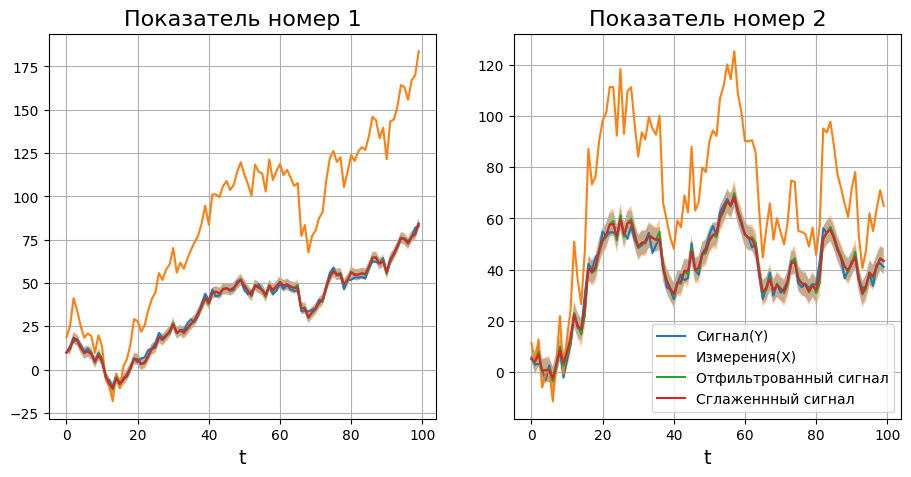

In [7]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(11,5))

ax1.grid()
ax1.set_title("Показатель номер 1", fontsize=16)
ax1.set_xlabel("t", fontsize=14)
ax1.plot(np.arange(T), ys[0,:])
ax1.plot(np.arange(T), xs[0,:])
ax1.plot(np.arange(T), sig[0,:])
ax1.plot(np.arange(T), smoothedSig[0,:])
ax1.fill_between(np.arange(T),smoothedSig[0,:]-1.96*np.sqrt(smoothedErrs[0,0,:]), smoothedSig[0,:]+1.96*np.sqrt(smoothedErrs[0,0,:]), alpha=0.4 )
ax1.fill_between(np.arange(T),sig[0,:]-1.96*np.sqrt(errs[0,0,:]), sig[0,:]+1.96*np.sqrt(errs[0,0,:]), alpha=0.4 )


ax2.grid()
ax2.set_title("Показатель номер 2", fontsize=16)
ax2.set_xlabel("t", fontsize=14)
ax2.plot(np.arange(T), ys[1,:])
ax2.plot(np.arange(T), xs[1,:])
ax2.plot(np.arange(T), sig[1,:])
ax2.plot(np.arange(T), smoothedSig[1,:])
ax2.fill_between(np.arange(T),smoothedSig[1,:]-1.96*np.sqrt(smoothedErrs[1,1,:]), smoothedSig[1,:]+1.96*np.sqrt(smoothedErrs[1,1,:]), alpha=0.4 )
ax2.fill_between(np.arange(T),sig[1,:]-1.96*np.sqrt(errs[1,1,:]), sig[1,:]+1.96*np.sqrt(errs[1,1,:]), alpha=0.4 )

ax2.legend(["Сигнал(Y)","Измерения(X)","Отфильтрованный сигнал","Сглаженнный сигнал"])
# plt.savefig('filtered.pdf')
plt.show()

Как всегда, выглядит отлично!

### Тестируем ЕМ на этом примере

А как всё будет работать, если попробовать ЕМ-алгоритм? Предположим, что мы НИЧЕГО не знаем априори и всё хотим выучить.

In [8]:
A = np.eye(2)
B = np.array([[1.9999,0.31],[-0.2,1.911]])
Ry = np.array([[2,0.00002],[0.00002,3]])*10
Rx = np.array([[1.3,0.0002],[0.0002,3]])*10
T=100

sigGen = LinearGaussianSignalGenerator(A, B, Ry, Rx)

startMean=np.array([10,5])
startCov=np.eye(2)*0.1

start = np.random.multivariate_normal(mean=startMean,cov=startCov)#np.array([10,5])
ys, xs = sigGen.generate(T,start)

In [9]:
startA = np.eye(2)
startB = np.eye(2)
startRy = np.eye(2)
startRx = np.eye(2)
startStartMean = np.ones([2])
startStartCov = np.eye(2)
filter = KalmanFilter(A=startA, B=startB, Ry=startRy, Rx=startRx, startMean=startStartMean,startCov=startStartCov)
filter.fit(xs, Niter=200)

 23%|██▎       | 46/200 [00:00<00:00, 221.70it/s]

[[0.38337177 0.        ]
 [0.         0.38337177]]
[104.49760921  89.81694845]
[[0.16367177 0.05952456]
 [0.05899046 0.34080511]]
[102.32918925  88.25795662]


 80%|████████  | 161/200 [00:00<00:00, 225.40it/s]

[[0.12371443 0.05460835]
 [0.06215297 0.33743689]]
[101.25371954  86.54793646]
[[0.09416626 0.04649836]
 [0.05979483 0.33632975]]
[100.61771402  84.87754646]


100%|██████████| 200/200 [00:00<00:00, 215.92it/s]


In [10]:
sig,errs,aprSig,aprErrs = filter.filterSignal(xs)
smoothedSig, smoothedErrs = filter.smoothSignal(sig,errs,aprSig,aprErrs)

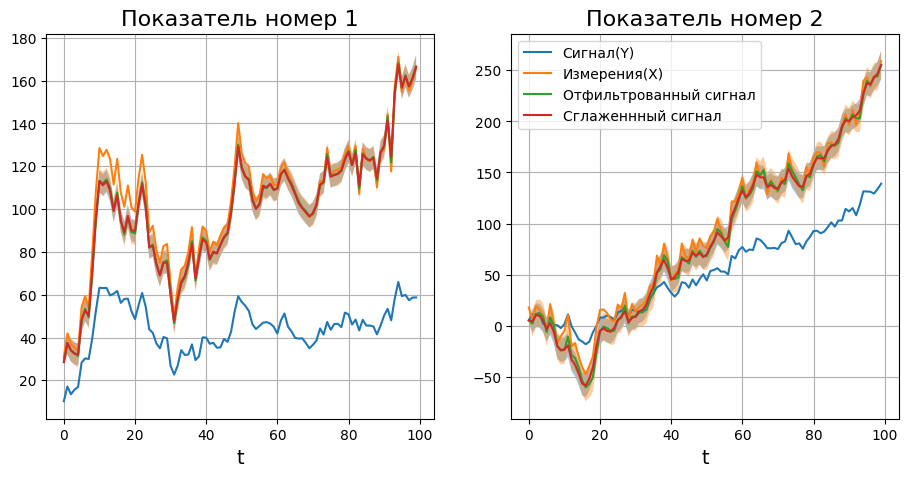

In [11]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(11,5))

ax1.grid()
ax1.set_title("Показатель номер 1", fontsize=16)
ax1.set_xlabel("t", fontsize=14)
ax1.plot(np.arange(T), ys[0,:])
ax1.plot(np.arange(T), xs[0,:])
ax1.plot(np.arange(T), sig[0,:])
ax1.plot(np.arange(T), smoothedSig[0,:])
ax1.fill_between(np.arange(T),smoothedSig[0,:]-1.96*np.sqrt(smoothedErrs[0,0,:]), smoothedSig[0,:]+1.96*np.sqrt(smoothedErrs[0,0,:]), alpha=0.4 )
ax1.fill_between(np.arange(T),sig[0,:]-1.96*np.sqrt(errs[0,0,:]), sig[0,:]+1.96*np.sqrt(errs[0,0,:]), alpha=0.4 )


ax2.grid()
ax2.set_title("Показатель номер 2", fontsize=16)
ax2.set_xlabel("t", fontsize=14)
ax2.plot(np.arange(T), ys[1,:])
ax2.plot(np.arange(T), xs[1,:])
ax2.plot(np.arange(T), sig[1,:])
ax2.plot(np.arange(T), smoothedSig[1,:])
ax2.fill_between(np.arange(T),smoothedSig[1,:]-1.96*np.sqrt(smoothedErrs[1,1,:]), smoothedSig[1,:]+1.96*np.sqrt(smoothedErrs[1,1,:]), alpha=0.4 )
ax2.fill_between(np.arange(T),sig[1,:]-1.96*np.sqrt(errs[1,1,:]), sig[1,:]+1.96*np.sqrt(errs[1,1,:]), alpha=0.4 )

ax2.legend(["Сигнал(Y)","Измерения(X)","Отфильтрованный сигнал","Сглаженнный сигнал"])
# plt.savefig('filtered.pdf')
plt.show()

Если позапускать ещё, становится понятно, что дело тут не в количестве итераций и не в точке старта (хотя если задать истинные параметры стартовыми, всё отлично). Алгоритм не ломается, проблем с обращением матриц нет, при этом мы видим, что одно из измерений почти попало в истинный сигнал.

Такой алгоритм не сойдётся к одному значению, потому что с точки зрения правдоподобия есть несколько одинаковых вариантов параметров, которые дадут ту же последовательность $X$. Например, если $B$ умножить на $5$, а $A$ поделить на 5, результат в $X$ не поменяется. Поэтому часть параметров нам придётся из задачи как-то узнать и зафиксировать, чтобы фильтр оценился. Обычно $B$ дана изначально, давайте её зафиксируем.

In [12]:
filter = KalmanFilter(A=startA, B=B, Ry=startRy, Rx=startRx, startMean=startStartMean,startCov=startStartCov)
filter.fit(xs, Niter=20, fixB=True)

100%|██████████| 20/20 [00:00<00:00, 206.54it/s]

[[ 0.17413612 -0.00745133]
 [-0.00745133  0.18327377]]
[44.31771171 51.65380895]


In [13]:
sig,errs,aprSig,aprErrs = filter.filterSignal(xs)
smoothedSig, smoothedErrs = filter.smoothSignal(sig,errs,aprSig,aprErrs)

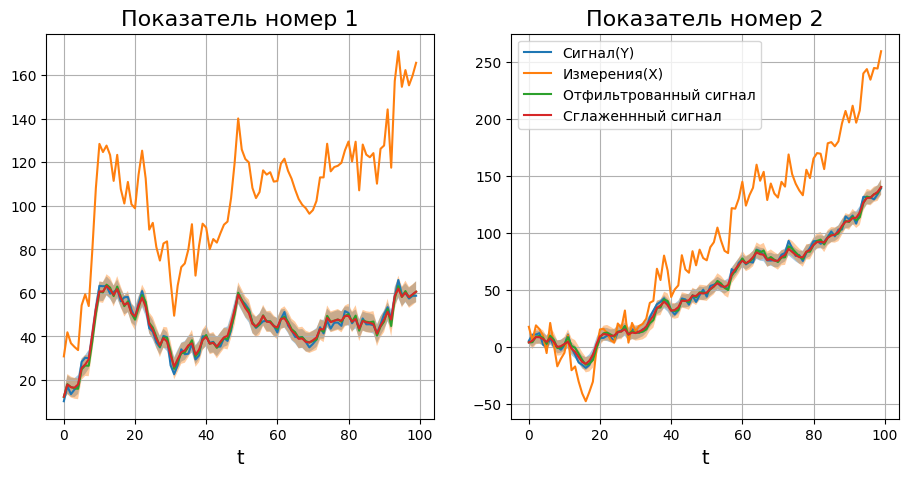

In [14]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(11,5))

ax1.grid()
ax1.set_title("Показатель номер 1", fontsize=16)
ax1.set_xlabel("t", fontsize=14)
ax1.plot(np.arange(T), ys[0,:])
ax1.plot(np.arange(T), xs[0,:])
ax1.plot(np.arange(T), sig[0,:])
ax1.plot(np.arange(T), smoothedSig[0,:])
ax1.fill_between(np.arange(T),smoothedSig[0,:]-1.96*np.sqrt(smoothedErrs[0,0,:]), smoothedSig[0,:]+1.96*np.sqrt(smoothedErrs[0,0,:]), alpha=0.4 )
ax1.fill_between(np.arange(T),sig[0,:]-1.96*np.sqrt(errs[0,0,:]), sig[0,:]+1.96*np.sqrt(errs[0,0,:]), alpha=0.4 )


ax2.grid()
ax2.set_title("Показатель номер 2", fontsize=16)
ax2.set_xlabel("t", fontsize=14)
ax2.plot(np.arange(T), ys[1,:])
ax2.plot(np.arange(T), xs[1,:])
ax2.plot(np.arange(T), sig[1,:])
ax2.plot(np.arange(T), smoothedSig[1,:])
ax2.fill_between(np.arange(T),smoothedSig[1,:]-1.96*np.sqrt(smoothedErrs[1,1,:]), smoothedSig[1,:]+1.96*np.sqrt(smoothedErrs[1,1,:]), alpha=0.4 )
ax2.fill_between(np.arange(T),sig[1,:]-1.96*np.sqrt(errs[1,1,:]), sig[1,:]+1.96*np.sqrt(errs[1,1,:]), alpha=0.4 )

ax2.legend(["Сигнал(Y)","Измерения(X)","Отфильтрованный сигнал","Сглаженнный сигнал"])
# plt.savefig('filtered.pdf')
plt.show()

Прекрасно! Причём сходится за десяток итераций.

## Оценка скорости движения и погрешности

А что в задаче, где есть ненаблюдаемые переменные? В прошлый раз мы проверяли на равномерно и прямолинейно движущемся велосипеде.

Модель мира выглядит так:

$$
Y_{t+1} = A Y_t + U_t, ~A = \begin{bmatrix}1 & \Delta t\\ 0 & 1 \end{bmatrix}.
$$

Мир описывается положением велосипеда (первая координата) и скоростью (вторая координата).

Наблюдаем мы только координату (по условному одномерному GPS):

$X_{t+1} = B Y_{t+1} + V_{t+1}, ~ B = [1,0] .$

Для определённости возьмём единичные матрицы в качестве дисперсий шумов, а стартовое состояние зададим с большей дисперсией.


In [15]:
deltaT = 0.1
A = np.eye(2)
A[0,1] = deltaT
A[1,1] = 1

B=np.array([[1,0]])

Ry = np.eye(2)
Rx = np.eye(1)*5

T=50

sigGen = LinearGaussianSignalGenerator(A, B, Ry, Rx)

startMean=np.array([0,10])
startCov=np.eye(2)*10

start = np.random.multivariate_normal(mean=startMean,cov=startCov)#np.array([10,5])
ys, xs = sigGen.generate(T,start)

filter = KalmanFilter(A, B, Ry, Rx,startMean,startCov)

In [16]:
startA = np.eye(2)
startB = B
startRy = np.eye(2)
startRx = Rx
startStartMean = np.ones([2])
startStartCov = np.eye(2)
filter = KalmanFilter(A=startA, B=startB, Ry=startRy, Rx=startRx, startMean=startStartMean,startCov=startStartCov)
filter.fit(xs, Niter=50,fixB=True)

100%|██████████| 50/50 [00:00<00:00, 388.52it/s]

[[0.63702345 0.        ]
 [0.         0.92858765]]
[23.28707491  1.        ]


In [17]:
sig,errs,aprSig,aprErrs = filter.filterSignal(xs)
smoothedSig, smoothedErrs = filter.smoothSignal(sig,errs,aprSig,aprErrs)

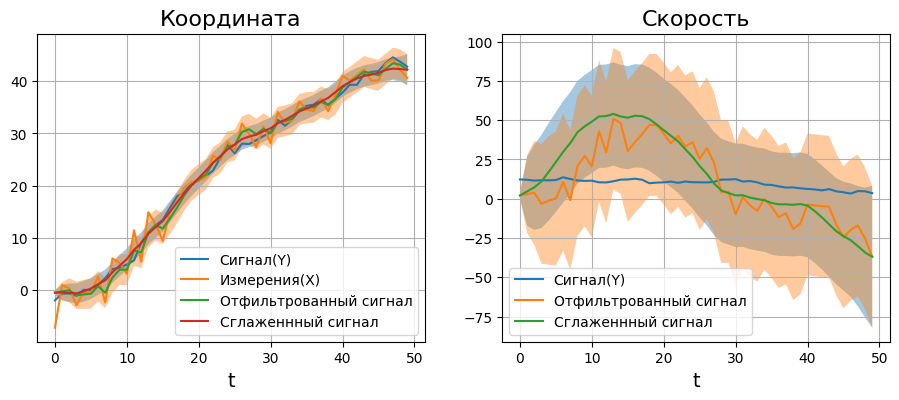

In [18]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(11,4))

ax1.grid()
ax1.set_title("Координата", fontsize=16)
ax1.set_xlabel("t", fontsize=14)
ax1.plot(np.arange(T), ys[0,:])
ax1.plot(np.arange(T), xs[0,:])
ax1.plot(np.arange(T), sig[0,:])
ax1.plot(np.arange(T), smoothedSig[0,:])
ax1.fill_between(np.arange(T),smoothedSig[0,:]-1.96*np.sqrt(smoothedErrs[0,0,:]), smoothedSig[0,:]+1.96*np.sqrt(smoothedErrs[0,0,:]), alpha=0.4 )
ax1.fill_between(np.arange(T),sig[0,:]-1.96*np.sqrt(errs[0,0,:]), sig[0,:]+1.96*np.sqrt(errs[0,0,:]), alpha=0.4 )
ax1.legend(["Сигнал(Y)", "Измерения(X)","Отфильтрованный сигнал","Сглаженнный сигнал"])


ax2.grid()
ax2.set_title("Скорость", fontsize=16)
ax2.set_xlabel("t", fontsize=14)
ax2.plot(np.arange(T), ys[1,:])
#ax2.plot(np.arange(T), xs[1,:])
ax2.plot(np.arange(T), sig[1,:])
ax2.plot(np.arange(T), smoothedSig[1,:])
ax2.fill_between(np.arange(T),smoothedSig[1,:]-1.96*np.sqrt(smoothedErrs[1,1,:]), smoothedSig[1,:]+1.96*np.sqrt(smoothedErrs[1,1,:]), alpha=0.4 )
ax2.fill_between(np.arange(T),sig[1,:]-1.96*np.sqrt(errs[1,1,:]), sig[1,:]+1.96*np.sqrt(errs[1,1,:]), alpha=0.4 )

ax2.legend(["Сигнал(Y)","Отфильтрованный сигнал","Сглаженнный сигнал"])
# plt.savefig('filtered.pdf')
plt.show()